In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

from ipywidgets import IntProgress

## Choosing nice colors for plot
#if you want to plot for k>3, extend these lists of colors
cmpd = ['orangered','dodgerblue','springgreen']
cmpcent = ['red','darkblue','limegreen']

# Soft clustering with Gaussian Mixture Models (GMM) 

The information provided by $k$ means is rather coarse-grained: 

-even if two data points belong to the same cluster, 
- their location within the cluster might be very different. 

Let us now consider soft-clustering methods which provide a more fine-grained information about the cluster structure of a data set. 

Considering again the customer segmentation for a Cafe business, 

In [5]:
#read in data from the csv file
df = pd.read_csv("data.csv")
data=df.values

#display first 5 rows, to get a feeling for the data
display(df.head(5))
print(data.shape)

,Age,Spending
0,28.018868,5.263333
1,27.897623,5.276452
2,29.042011,4.794357
3,29.669165,5.207227
4,29.494291,6.351539


(400, 2)




### we might like to have some measure for the __extend__ (or __degree__) by which a customer belongs to various groups. 

This is a soft-clustering problem where we associate 

- each data point $\mathbf{x}^{(i)}$(which represents a particular customer) with
- a membership-vector $\mathbf{y}^{(i)}= (y^{(i)}_1,...,y^{(i)}_k) \in [0,1]^k$ whose entry $y^{(i)}_c$ is the degree by which we assign $\mathbf{x}^{(i)}$ to cluster $\mathcal{C}_c$.

A principled approach to obtaining a soft-clustering method is based on interpreting the data points $\mathbf{x}^{(i)}$ as realizations of a random vector $\mathbf{x}$ with some underlying probability distribution $p(\mathbf{x})$. In particular, we can represent 
- a cluster $\mathcal{C}_{c}$ by a Gaussian distribution with
- mean vector $\mathbf{m}^{(c)}$ and 
- covariance matrix $\mathbf{C}^{(c)}$. 

The probability density function of such a Gaussian distribution is denoted 

\begin{equation}
\mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)}) = \frac{1}{\sqrt{{\rm det} \big(2 \pi \mathbf{C}^{(c)}\big)}} {\rm exp } \bigg( - \big(\mathbf{x}^{(i)} - \mathbf{m}^{(c)} \big)^{T} \big(\mathbf{C}^{(c)}\big)^{-1}  \big(\mathbf{x}^{(i)} - \mathbf{m}^{(c)} \big)\bigg).
\end{equation}

The overall probability distribution is then obtained as a **Gaussian mixture** 

\begin{equation}
p(\mathbf{x}) = p_{1} \mathcal{N}(\mathbf{x} ; \mathbf{m}^{(1)}, \mathbf{C}^{(1)}) + p_{2} \mathcal{N}(\mathbf{x} ; \mathbf{m}^{(2)}, \mathbf{C}^{(2)})
\end{equation}




with coefficients $p_{1},p_{2} \geq 0$ satisfying $p_{1} + p_{2} =1$. The coefficient $p_{1}$ is the probability that a data point is drawn from cluster $\mathcal{C}_{1}$ and, similarly, $p_{2}$ is the probability that a data point is drawn from cluster $\mathcal{C}_{2}$. Note that the distribution $p(\mathbf{x})$ depends (is parametrized by) the coefficients $p_{1},p_{2}$, the cluster means $\mathbf{m}^{(1)},\mathbf{m}^{(2)}$ 
and the covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)}$. This is when we set the number of clusters to 2, but just as in k-means we can also set it to another number. 


Under the probabilistic model $p(\mathbf{x})$, the degree $y_{c}^{(i)}$ of a data point $\mathbf{x}^{(i)}$ belonging to cluster $\mathcal{C}_{c}$ can be defined as the probability that $\mathbf{x}^{(i)}$ is generated (drawn) from the Gaussian distribution associated with $\mathcal{C}_{c}$:  

$$\mathbf{y}^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c')}, \mathbf{C}^{(c')})} $$

After determining the degrees of belonging, we can then update or guess (estimate) the cluster probabilities $p_{1},p_{2}$, cluster means $\mathbf{m}^{(1)}, \mathbf{m}^{(2)}$ and covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)}$.

In summary this algorithm consists of 4 steps (just as k-means):

* __Step 1 - Initialize the cluster parameters. This are the means and covariances for every cluster.__
* __Step 2 - Update the degree of data point \mathbf{x}^{(i)} belonging to cluster c.__
* __Step 3 - Update the cluster parameters, i.e. the means and covariances.__
* __Step 4 - Put steps 2 and 3 in a loop__

So lets go through these steps one by one and compose the algorithm. 

### Step 1: Initialize the cluster parameters

We first choose an initial mean, covariance matrix and coefficient for each cluster. The means are initialized randomly,as initialization for the covariance matrix we take the identity matrix and all coefficients are set to 0.5. 

In [3]:
def initialize_parameters(data, k,random_seed=1):
    
    # Random seed will generate exactly same "random" values for each execution.
    # This will ensure similar results between students and avoid confusion.
    np.random.seed(seed=random_seed)
    
    means = np.zeros((k, data.shape[1]))
    for i in range(data.shape[1]):
        means[:,i] = np.random.uniform(np.min(data[:,i]), 
                                           np.max(data[:,i]), 
                                           size = (k)) 
    covariances=np.zeros((k,data.shape[1],data.shape[1]))
    
    for f in range(k):
        covariances[f]=np.identity(data.shape[1])
    coefficients=np.ones(k)*0.5
    return means, covariances,coefficients

In [4]:
def plot_GMM(data,means,covariances,k,cluster_vectors=None):
    if cluster_vectors is None:
        plt.scatter(data[:,0], data[:,1], s=13,alpha=0.5)
    else:
        clusters = np.argmax(cluster_vectors,axis=0)
        plt.scatter(data[:,0], data[:,1], c=[cmpd[i] for i in clusters], s=13,alpha=0.5)

    #Visualization of results
    x_plot = np.linspace(19,35, 100)
    y_plot = np.linspace(0,12, 100)

    for i in range(k):
        x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
        z= plt.mlab.bivariate_normal(x_mesh, y_mesh, np.sqrt(covariances[i,0, 0]), \
                                    np.sqrt(covariances[i,1, 1]), means[i,0], means[i,1],covariances[i,0,1])
        plt.contour(x_mesh , y_mesh , z,4,colors=cmpcent[i],alpha=0.5)
        plt.scatter( [means[i,0]], [means[i,1]], marker='x',c=cmpcent[i])

    plt.title("Soft clustering with GMM")
    plt.xlabel("feature x_1: customers' age")
    plt.ylabel("feature x_2: money spent during visit")
    plt.show()

Let's calculate and plot the initializations. The circles indicate the probability distribution, based on the covariances. 

/home/adam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  


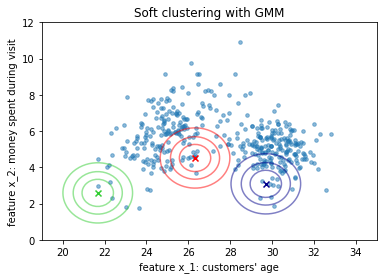

In [8]:
means,covariances,coefficients=initialize_parameters(data,3)
plot_GMM(data,means,covariances,3)

### Step 2: Assign a probability for each datapoint belonging to each cluster

We now want to calculate for each datapoint the probability it belongs to each cluster. The probability of belonging to a cluster, is also called the degree of belonging. We can calculate this by the following formula:

$$y^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c')} , \mathbf{C}^{(c')})} $$

Here, $\mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{m}^{(c)}, \mathbf{C}^{(c)})$ is the probability density function (or pdf for short). 

In [9]:
from scipy.stats import multivariate_normal # Multivariate normal random variable


def update_degrees_of_belonging(data, means, covariances,coefficients,k): 
    cluster_vectors=np.zeros((k,data.shape[0]))   
    for i in range(data.shape[0]):
        belonging_all=np.sum([coefficients[f]*multivariate_normal.pdf(data[i],means[f],covariances[f]) for f in range(k)])
        for t in range(k):
            cluster_vectors[t,i]=coefficients[t]*multivariate_normal.pdf(data[i],means[t],covariances[t])/belonging_all
    
    return cluster_vectors

/home/adam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  


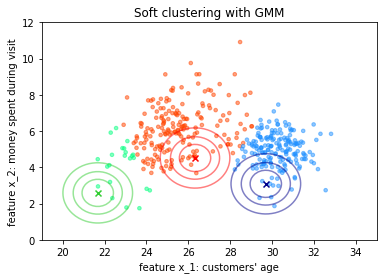

In [10]:
cluster_vectors=update_degrees_of_belonging(data,means,covariances,coefficients,3)
plot_GMM(data,means,covariances,3,cluster_vectors)

### Step 3: Set the new cluster parameters

Now we want to update the cluster parameters. In contrast to $k$-means, where we only updated the clusters means here we also have to update the covariances and coefficients. Since we use degrees of belonging the formula for updating the means is also slightly different compared to k-means. See the updating formulas below. 

$$p_{c}=\frac{N_{c}}{N}$$
$$\mathbf{m}^{(c)} = \frac{1}{N_c} \sum_{i=1}^N y_c^{(i)}\mathbf{x}^{(i)} $$
$$\mathbf{C}^{(c)} = \frac{1}{N_c} \sum_{i=1}^N y_c^{(i)}(\mathbf{x}^{(i)} - \mathbf{m}^{(c)})(\mathbf{x}^{(i)} - \mathbf{m}^{(c)})^T $$
where $N_c = \sum_{i=1}^N y_c^{(i)}$

In [12]:
def update_GMM_pars(data, cluster_vectors,k): 
    means_new = np.zeros((k, data.shape[1]))
    covariances_new=np.zeros((k,data.shape[1],data.shape[1]))
    coefficients_new=np.zeros(k)
    
    for i in range(k):
        sum_k=np.sum(cluster_vectors[i])
        coefficients_new[i]=sum_k/len(data)
        means_new[i]=data.T@cluster_vectors[i]/sum_k
        for l in range(data.shape[0]):
            covariances_new[i]+=np.outer( data[l] - means_new[i], data[l] - means_new[i]) * cluster_vectors[i,l]
        covariances_new[i]=covariances_new[i]/sum_k
    return means_new,covariances_new,coefficients_new

/home/adam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  


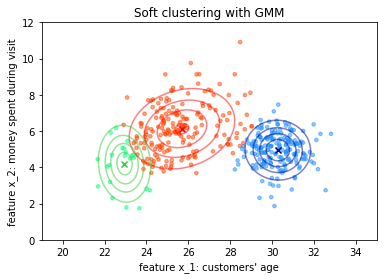

In [13]:
means,covariances,coefficients=update_GMM_pars(data, cluster_vectors,3)
plot_GMM(data,means,covariances,3,cluster_vectors)

### Step 4: Put steps 2 and 3 in a loop

The last step is to put all the pieces together by initializing the parameters and then putting step 2 and 3 inside a loop. This is very similar to the process in k-means. 

In [15]:
def GMM_clustering(data,k,num_iters,random_seed=0):
    # Step 1: 
    means,covariances,coefficients = initialize_parameters(data,k,random_seed)
    
    # This will display a progress bar during GMM execution
    f = IntProgress(description=f'GMM (k={k}):',min=0, max=num_iters)
    display(f)
    for i in range(num_iters):
        # Step 2:
        cluster_vectors = update_degrees_of_belonging(data, means, covariances,coefficients,k)
        # Step 3:
        means,covariances,coefficients=update_GMM_pars(data, cluster_vectors,k)
        
        # Iterate progress bar
        f.value +=1
    
    return means, covariances, cluster_vectors

### Calculate the final means and covariance matrices and plot the result

In the plot we can clearly see an overlap of the clusters, i.e. some points belonging to in this case 2 clusters. What does this mean and how would this influence the customer segmentation and marketing strategy for the cafe?

IntProgress(value=0, description='GMM (k=3):', max=50)

/home/adam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  


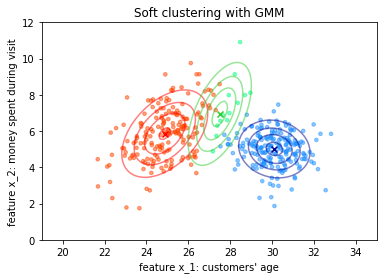

The means are [[24.87515077  5.8639891 ]
 [30.109949    5.01680331]
 [27.5002508   6.95363818]]
The covariance matrices are [[[ 1.48998332  0.81579883]
  [ 0.81579883  2.05972989]]

 [[ 0.98782389 -0.10801821]
  [-0.10801821  0.8659114 ]]

 [[ 0.77271062  0.80393491]
  [ 0.80393491  2.73324751]]]


In [17]:
means,covariances,cluster_vectors=GMM_clustering(data,3,50)
plot_GMM(data,means,covariances,3,cluster_vectors)
print("The means are",means)
print("The covariance matrices are",covariances)